<a href="https://colab.research.google.com/github/Ayushi-1903/DEEP-LEARNING-PROJECT/blob/main/Task_2_Deep_Learning_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name : AYUSHI VERMA

üì¶ Import Libraries
Loads required libraries like TensorFlow, NumPy, Matplotlib, etc. for image processing and model training.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

üå∏ Load Dataset:
Loads the 'tf_flowers' dataset from TensorFlow Datasets and splits it into training and test sets.

In [2]:
(dataset_train, dataset_test), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

print("Classes:", dataset_info.features['label'].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.2U7MEK_3.0.1/tf_flowers-train.tfrecord*...:   0%|   ‚Ä¶

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


Compute Channel Statistics:
Resizes images and calculates mean and standard deviation per color channel for normalization.

In [3]:
IMG_SIZE = 128  # Or any other desired size
all_images = []
for img, _ in dataset_train:
    all_images.append(tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy())

all_images = np.stack(all_images)
channel_means = all_images.mean(axis=(0, 1, 2)) / 255.0
channel_stds = all_images.std(axis=(0, 1, 2)) / 255.0

print("Channel Means:", channel_means)
print("Channel STDs:", channel_stds)

Channel Means: [0.35014158 0.35014158 0.27289626]
Channel STDs: [0.29237634 0.25405368 0.26644385]


üñºÔ∏è Resize and Store Train Images:
Resizes training images to uniform size and stores them along with labels as NumPy arrays.



In [4]:

train_images = []
train_labels = []
for image, label in dataset_train:
    resized_image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    train_images.append(resized_image.numpy())
    train_labels.append(label.numpy())

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(f"train_images shape: {train_images.shape}")
print(f"train_labels shape: {train_labels.shape}")

train_images shape: (2936, 128, 128, 3)
train_labels shape: (2936,)


üìä Plot Pixel Distributions: Plots histograms of pixel values per RGB channel before normalization to visualize distribution.

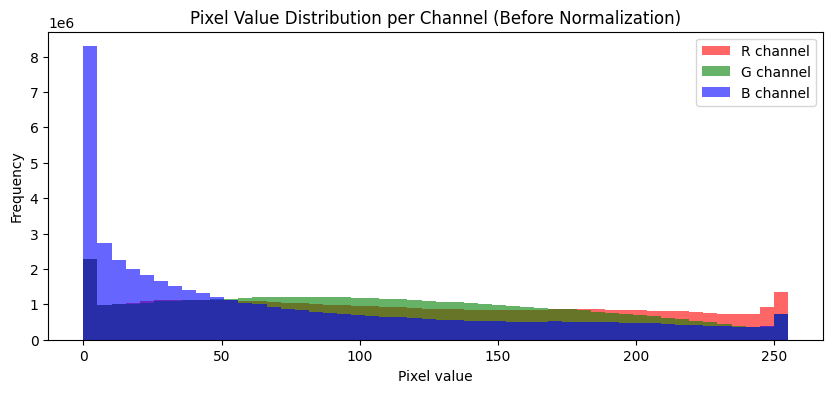

In [5]:
# Plot per-channel pixel value distributions
colors = ['r', 'g', 'b']
plt.figure(figsize=(10, 4))
for i, color in enumerate(colors):
    if train_images.ndim == 4:  # Expecting (num_samples, height, width, channels)
        plt.hist(train_images[:, :, :, i].flatten(), bins=50, color=color, alpha=0.6, label=f'{color.upper()} channel')
    else:
        print("Error: train_images does not have the expected dimensions for plotting.")
plt.title("Pixel Value Distribution per Channel (Before Normalization)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

üß™ Resize and Store Test Images:
Processes test images similarly for evaluation purposes.

In [6]:
test_images = []
test_labels = []
for image, label in dataset_test:
    resized_image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    test_images.append(resized_image.numpy())
    test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Now you can normalize test_images
x_train = (train_images / 255.0 - channel_means) / channel_stds
x_test = (test_images / 255.0 - channel_means) / channel_stds


üîÑ Data Augmentation:
Defines a sequential augmentation pipeline (flip, rotation, zoom) to artificially expand the training data.

üëÄ Display Original & Augmented Images:
Plots original and augmented versions of sample images for visual comparison.

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

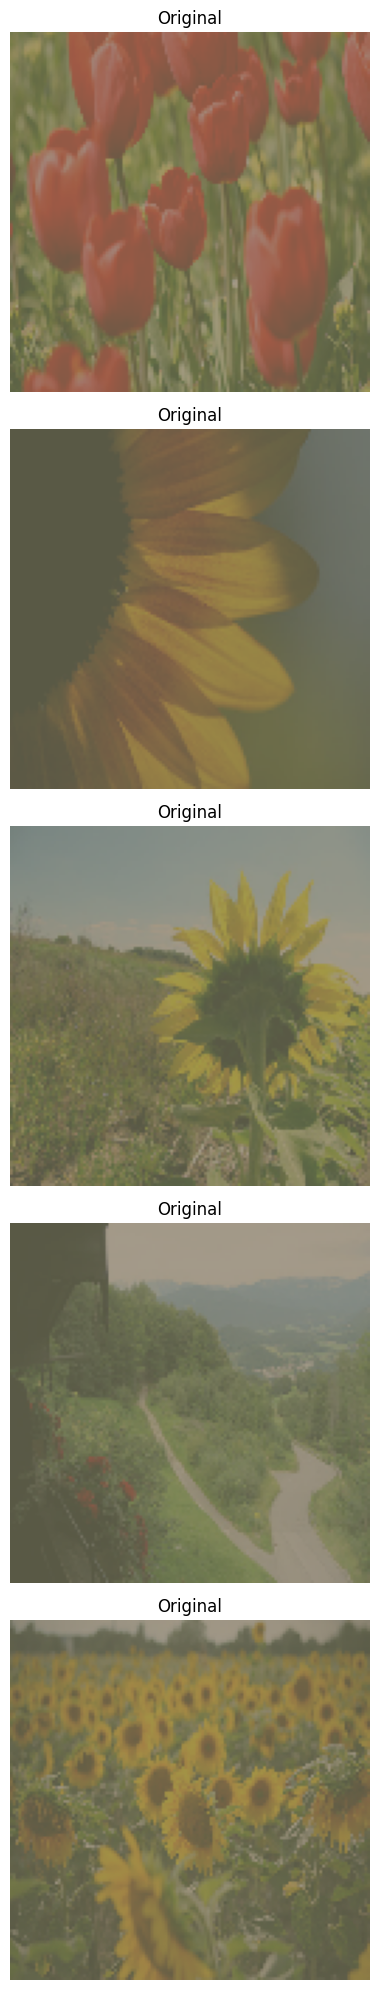

In [8]:
num_images = 5
sample_images = train_images[:num_images]

plt.figure(figsize=(10, 4 * num_images))

for i in range(num_images):
    # De-normalize the image
    image = sample_images[i] / 255.0
    image = image * channel_stds + channel_means
    image = np.clip(image * 255.0, 0, 255).astype(np.uint8)

    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()

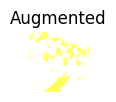

In [9]:
img_tensor = tf.convert_to_tensor(sample_images[i])
aug_img = data_augmentation(img_tensor, training=True)

# De-normalize augmented image
denorm_img = (aug_img.numpy() * channel_stds + channel_means) * 255.0
denorm_img = np.clip(denorm_img, 0, 255).astype(np.uint8)

plt.subplot(num_images, 2, 2 * i + 2)
plt.imshow(denorm_img)
plt.title("Augmented")
plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(10000).map(lambda x, y: (data_augmentation(x), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

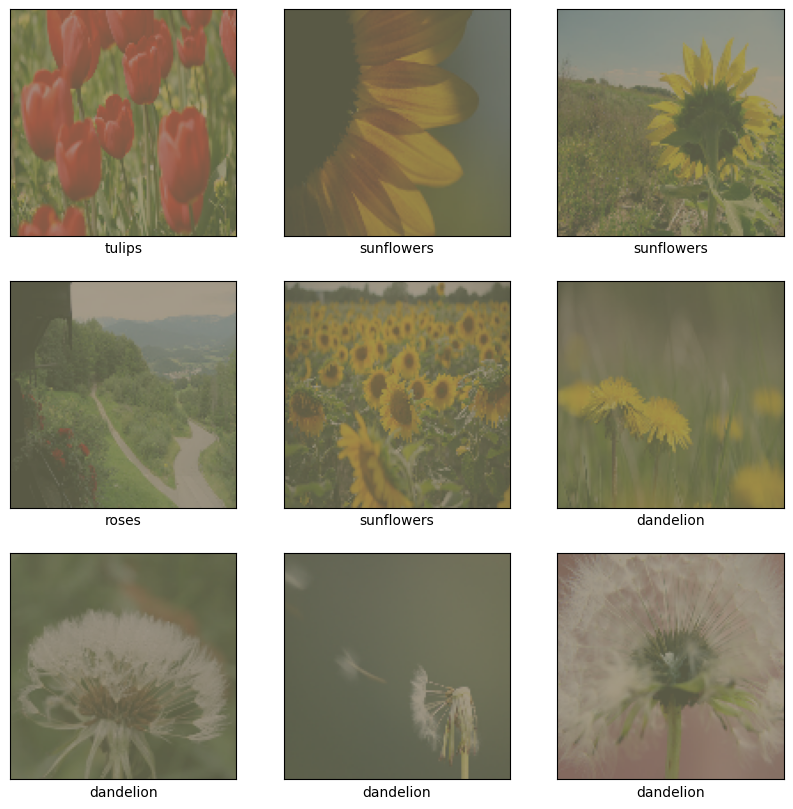

In [11]:
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # De-normalize the image for display
    image = train_images[i] / 255.0  # First normalize to [0,1]
    image = image * channel_stds + channel_means  # Un-normalize using stats
    image = np.clip(image * 255.0, 0, 255).astype(np.uint8)  # Rescale to [0,255]

    plt.imshow(image)
    flower_class_name = class_names[train_labels[i]]
    plt.xlabel(flower_class_name)  # Display the flower class name
plt.show()

üß† Define CNN Model:
Builds a sequential convolutional neural network for image classification.

‚öôÔ∏è Compile Model:
Sets the optimizer, loss function, and evaluation metric for model training.

üèãÔ∏è Train Model:
Trains the CNN on the training dataset and evaluates it on the validation (test) dataset.

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)), # Use IMG_SIZE here
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(dataset_info.features['label'].num_classes) # Output layer with correct number of classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 87s 924ms/step - accuracy: 0.2281 - loss: 63.1952 - val_accuracy: 0.2207 - val_loss: 1.6026
Epoch 2/10
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 139s 890ms/step - accuracy: 0.3460 - loss: 1.5087 - val_accuracy: 0.2207 - val_loss: 1.6476
Epoch 3/10
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 898ms/step - accuracy: 0.3967 - loss: 1.4050 - val_accuracy: 0.2180 - val_loss: 1.7618
Epoch 4/10
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 147s 950ms/step - accuracy: 0.5048 - loss: 1.1994 - val_accuracy: 0.2330 - val_loss: 2.2527
Epoch 5/10
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 137s 899ms/step - accuracy: 0.5575 - loss: 1.0309 - val_accuracy: 0.2452 - val_loss: 2.4266
Epoch 6/10
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 143s 907ms/step - accuracy: 0.6514 - loss: 0.8492 - val_accuracy: 0.2289 

üìà Plot Training History:
Visualizes training and validation accuracy and loss over epochs.

Text(0.5, 1.0, 'Accuracy Over Epochs')

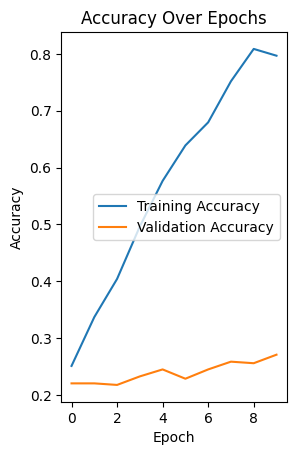

In [15]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

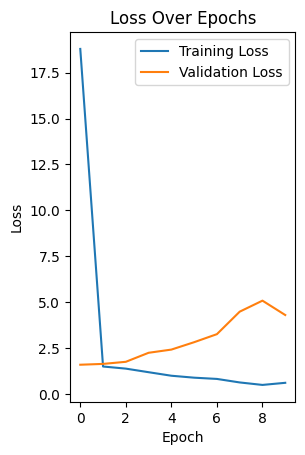

In [16]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

üß™ Evaluate Test Accuracy:
Evaluates the final model on test images and prints the accuracy.

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

23/23 - 5s - 210ms/step - accuracy: 0.2711 - loss: 4.3079

Test accuracy: 27.11%


üìä Make Predictions:
Adds a Softmax layer and makes probability predictions on test images.

In [18]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 227ms/step


In [19]:
def plot_image(i, predictions_array, true_label, img):
    # Access the true label directly if it's a 1D array
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"Pred: {class_names[predicted_label]} ({100*np.max(predictions_array):.0f}%) \n True: {class_names[true_label]}", color=color)

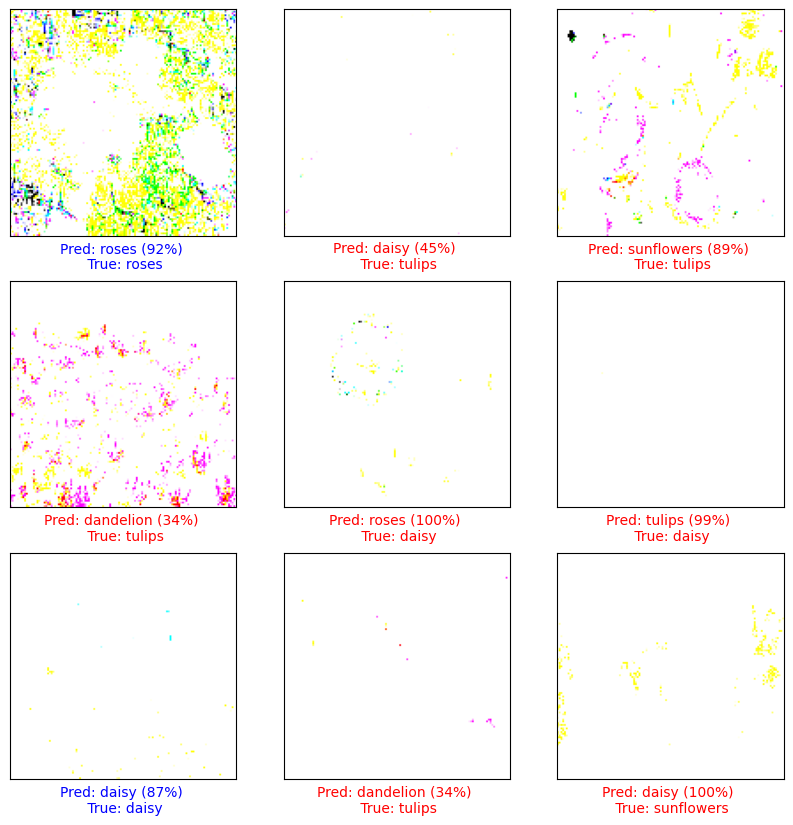

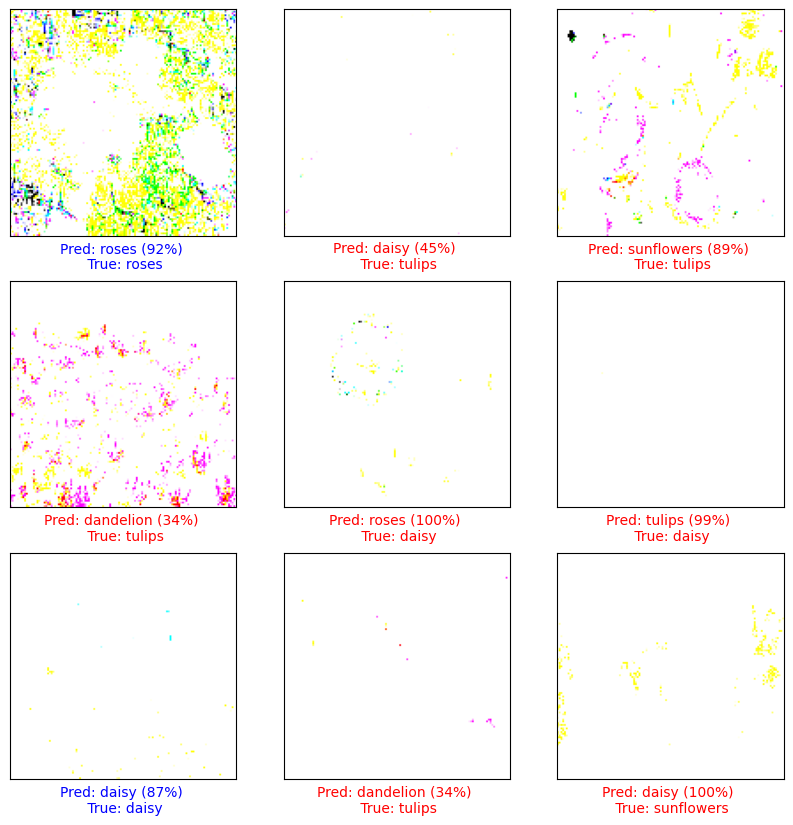

In [20]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plot_image(i, predictions[i], test_labels, test_images)
plt.show()
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plot_image(i, predictions[i], test_labels, test_images)
plt.show()

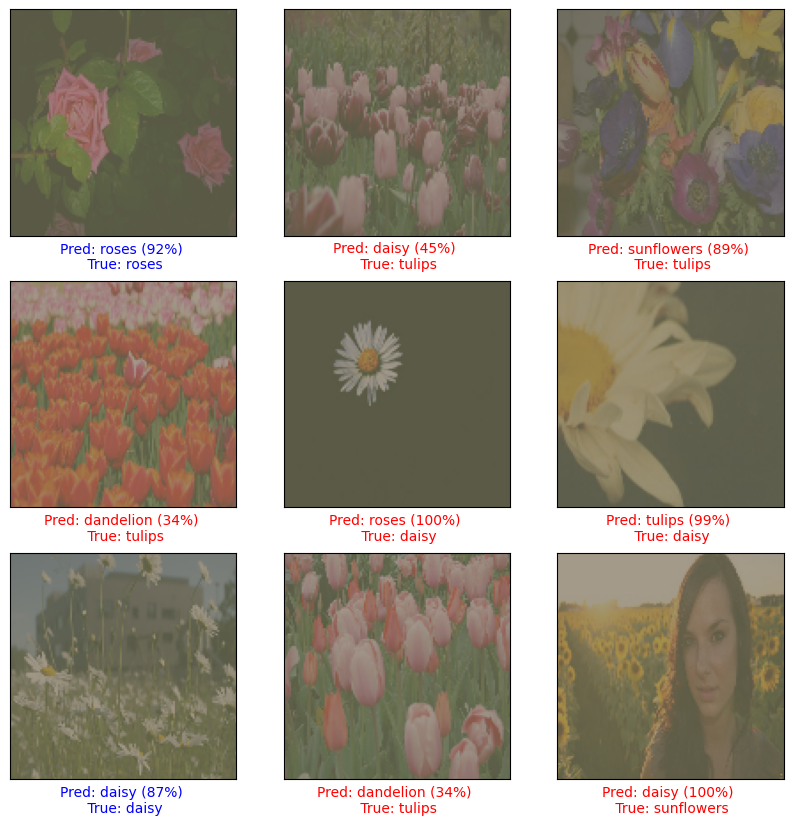

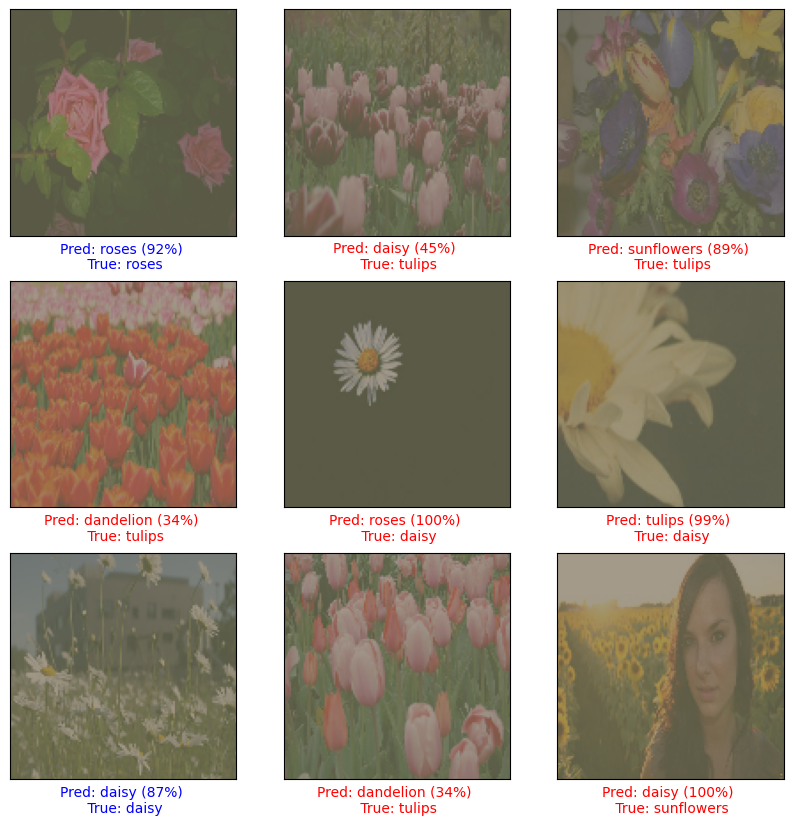

In [21]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # De-normalize the image for display
    image = img / 255.0  # First normalize to [0,1]
    image = image * channel_stds + channel_means  # Un-normalize using stats
    image = np.clip(image * 255.0, 0, 255).astype(np.uint8)  # Rescale to [0,255]

    plt.imshow(image)  # Display the de-normalized image

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"Pred: {class_names[predicted_label]} ({100*np.max(predictions_array):.0f}%) \n True: {class_names[true_label]}", color=color)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plot_image(i, predictions[i], test_labels, test_images)
plt.show()
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plot_image(i, predictions[i], test_labels, test_images)
plt.show()

Image 1


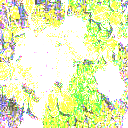

Image 2


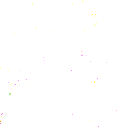

Image 3


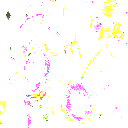

Image 4


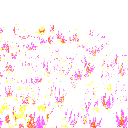

Image 5


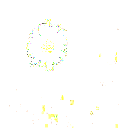

Image 6


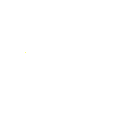

In [22]:
import IPython.display as display
from PIL import Image
import io
import numpy as np

# Select a few images from the validation (test) set
val_images = test_images[:6]  # First 6 test images

for i in range(6):
    # De-normalize the image for display
    image = val_images[i]
    image = image * channel_stds + channel_means  # Un-normalize using stats
    img_array = np.clip(image * 255.0, 0, 255).astype(np.uint8) # Rescale to [0,255]

    img = Image.fromarray(img_array)

    # Convert to PNG bytes
    with io.BytesIO() as output:
        img.save(output, format="PNG")
        image_data = output.getvalue()

    print(f"Image {i+1}")
    display.display(display.Image(data=image_data))

üéØ Final Test Set Visualization:
Predicts and plots true vs predicted labels on 10 test samples using color-coded titles.

2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 234ms/step


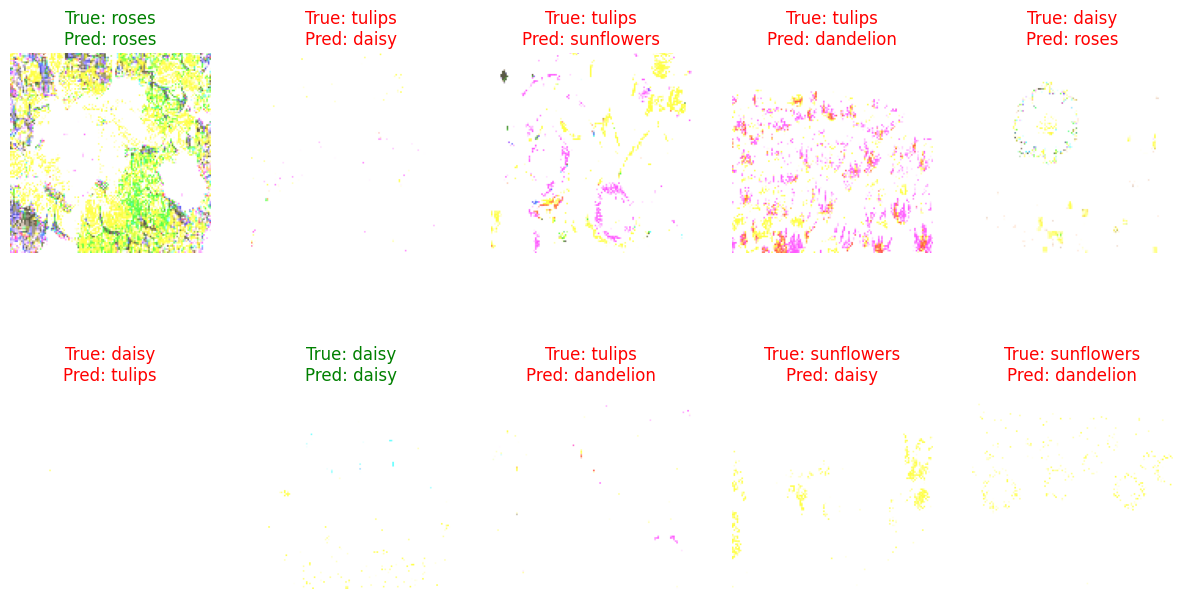

In [23]:
class_names = dataset_info.features['label'].names

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(2, 5, i+1)

        # De-normalize image
        img = images[i].numpy()
        img = (img * channel_stds + channel_means) * 255.0
        img = np.clip(img, 0, 255).astype(np.uint8)

        plt.imshow(img)

        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[predicted_labels[i]]
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.show()


Implements transfer learning using MobileNetV2 (with frozen base), adds custom layers, and trains on flower dataset for 5 epochs.

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Preprocess images for MobileNetV2
x_train_mobilenet = preprocess_input(train_images.copy())
x_test_mobilenet = preprocess_input(test_images.copy())

# Create model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze base

model_transfer = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')
])

model_transfer.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history_transfer = model_transfer.fit(
    x_train_mobilenet, train_labels,
    validation_data=(x_test_mobilenet, test_labels),
    epochs=5
)


9406464/9406464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step
Epoch 1/5
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 50s 478ms/step - accuracy: 0.6506 - loss: 0.9439 - val_accuracy: 0.8569 - val_loss: 0.3679
Epoch 2/5
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 465ms/step - accuracy: 0.8965 - loss: 0.2915 - val_accuracy: 0.8801 - val_loss: 0.3255
Epoch 3/5
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 462ms/step - accuracy: 0.9214 - loss: 0.2132 - val_accuracy: 0.8883 - val_loss: 0.3119
Epoch 4/5
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 473ms/step - accuracy: 0.9498 - loss: 0.1557 - val_accuracy: 0.8815 - val_loss: 0.3263
Epoch 5/5
92/92 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 465ms/step - accuracy: 0.9733 - loss: 0.1063 - val_accuracy: 0.8869 - val_loss: 0.3264


Generates and displays a confusion matrix heatmap and classification report to evaluate model performance on the test set.

23/23 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 278ms/step


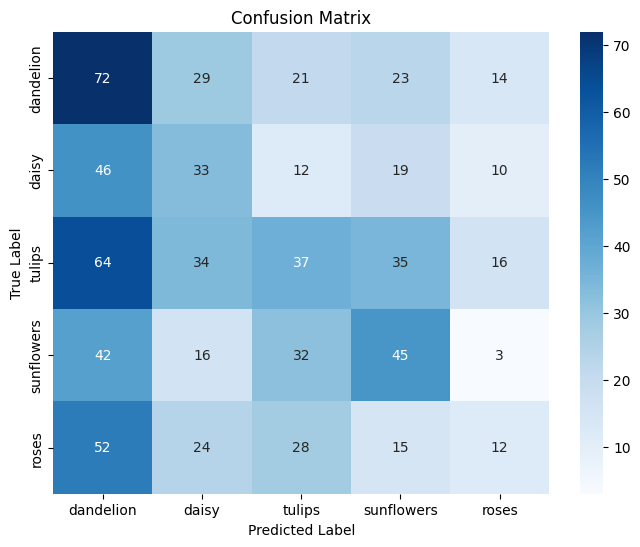

              precision    recall  f1-score   support

   dandelion       0.26      0.45      0.33       159
       daisy       0.24      0.28      0.26       120
      tulips       0.28      0.20      0.23       186
  sunflowers       0.33      0.33      0.33       138
       roses       0.22      0.09      0.13       131

    accuracy                           0.27       734
   macro avg       0.27      0.27      0.26       734
weighted avg       0.27      0.27      0.26       734



In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on test set
y_pred = np.argmax(model.predict(test_images), axis=1)

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(test_labels, y_pred, target_names=class_names))


Calculates per-class accuracy, displays CNN layer outputs, predicts top-3 class probabilities for a test image, and visualizes the sample image by using t-SNE.

In [26]:
from sklearn.manifold import TSNE

In [27]:
correct = np.zeros(len(class_names))
total = np.zeros(len(class_names))
for i in range(len(test_labels)):
    label = test_labels[i]
    pred = y_pred[i]
    if label == pred:
        correct[label] += 1
    total[label] += 1

print("\nPer-class Accuracy:")
for i in range(len(class_names)):
    acc = 100 * correct[i] / total[i]
    print(f"{class_names[i]}: {acc:.2f}%")



Per-class Accuracy:
dandelion: 45.28%
daisy: 27.50%
tulips: 19.89%
sunflowers: 32.61%
roses: 9.16%


In [28]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ‚Äî {layer.output.shape}")

0: conv2d ‚Äî (None, 126, 126, 32)
1: max_pooling2d ‚Äî (None, 63, 63, 32)
2: conv2d_1 ‚Äî (None, 61, 61, 64)
3: max_pooling2d_1 ‚Äî (None, 30, 30, 64)
4: conv2d_2 ‚Äî (None, 28, 28, 64)
5: flatten ‚Äî (None, 50176)
6: dense ‚Äî (None, 64)
7: dense_1 ‚Äî (None, 5)


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step


Top-3 predictions:
tulips: 38.33%
roses: 34.08%
daisy: 14.46%


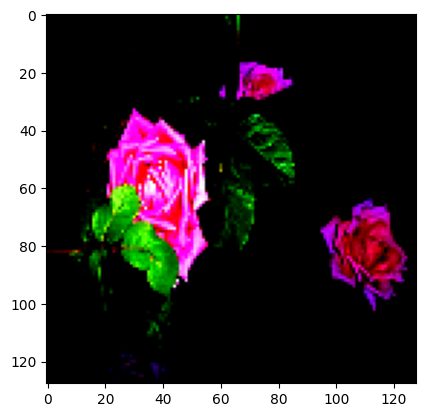

In [29]:
# Predict Top-3 Labels
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt

sample_img = x_test[0:1]
probs = tf.nn.softmax(model.predict(sample_img)).numpy()[0]
top_3 = np.argsort(probs)[-3:][::-1]
print("Top-3 predictions:")
for i in top_3:
    print(f"{class_names[i]}: {probs[i]*100:.2f}%")

# Display the image if you want to see it (optional)
plt.imshow(sample_img[0])
plt.show()